In [1]:
import csv
import os

import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
from PIL import Image

np.warnings.filterwarnings('ignore')

In [2]:
DISTRIBUTIONS = ["beta", "norm", "expon", "uniform", "laplace"]
RGB = ["r", "g", "b"]
fieldnames = [
    "r_max", "g_max", "b_max",
    "r_min", "g_min", "b_min",
    "r_mean", "g_mean", "b_mean",
    "r_var", "g_var", "b_var",
    "r_median", "g_median", "b_median",
    "r_iqr", "g_iqr", "b_iqr",
    "r_skewness", "g_skewness", "b_skewness",
    "r_kurtosis", "g_kurtosis", "b_kurtosis",
    "mse_norm", "mse_expon", "mse_uniform", "mse_beta", "mse_laplace"
]

In [3]:
class Img(object):
    
    def __init__(self, array):
        self.img = array
    
    @property
    def im_max(self):
        return [np.amax(self.img[:, :, ch]) for ch in range(self.img.shape[-1])]

    @property
    def im_min(self):
        return [np.amin(self.img[:, :, ch]) for ch in range(self.img.shape[-1])]
    
    @property
    def im_mean(self):
        return [np.mean(self.img[:, :, ch]) for ch in range(self.img.shape[-1])]

    @property
    def im_var(self):
        return [np.var(self.img[:, :, ch]) for ch in range(self.img.shape[-1])]

    @property
    def im_median(self):
        return [np.median(self.img[:, :, ch]) for ch in range(self.img.shape[-1])]

    @property
    def im_iqr(self):
        return [scipy.stats.iqr(self.img[:, :, ch]) for ch in range(self.img.shape[-1])]
    
    @property
    def im_skewness(self):
        return [scipy.stats.skew(self.img[:, :, ch], axis=None) for ch in range(self.img.shape[-1])]
    
    @property
    def im_kurtosis(self):
        return [scipy.stats.kurtosis(self.img[:, :, ch], axis=None) for ch in range(self.img.shape[-1])]
        

![alt text](L1.png "Title")

### 1. Test package

In [4]:
filename = "../JImages/im24732.jpg"
filename_output = "output.csv"
images_dir = "../JImages/"
image = np.array(Image.open(filename))
image.shape

(334, 500, 3)

### 2. Calculate mean, var, skew, kurtosis for input images

In [5]:
img = Img(image)


def get_properties(img):
    result = dict()
    for prop in dir(img):
        
        if prop.startswith("im_"):
            r_res, g_res, b_res = getattr(img, prop)
            result.update({f"r_{prop[3:]}": r_res, f"g_{prop[3:]}": g_res, f"b_{prop[3:]}": b_res})
    return result

# get_properties(img)

### 3. Build distribution histogram for pixel values for all color channels
### 4. Estimate distribution approximation

r_iqr: 69.0
g_iqr: 73.0
b_iqr: 64.0
r_kurtosis: -0.5676110559260144
g_kurtosis: -0.7073475737951354
b_kurtosis: -0.533043851903729
r_max: 255
g_max: 255
b_max: 255
r_mean: 117.88677844311377
g_mean: 125.94007784431138
b_mean: 117.0398622754491
r_median: 114.0
g_median: 121.0
b_median: 111.0
r_min: 0
g_min: 0
b_min: 4
r_skewness: 0.1946941709280496
g_skewness: 0.21674452594920188
b_skewness: 0.41790225588965013
r_var: 2282.4185102203733
g_var: 2310.3519722095093
b_var: 1962.8815187834277


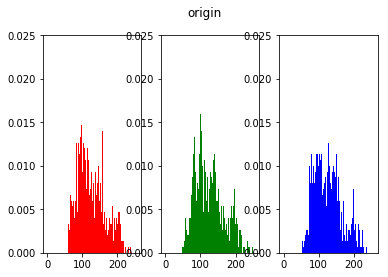

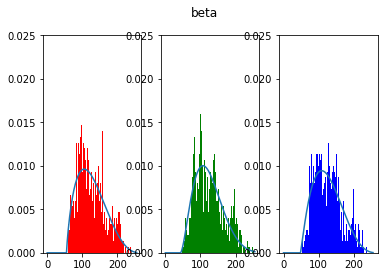

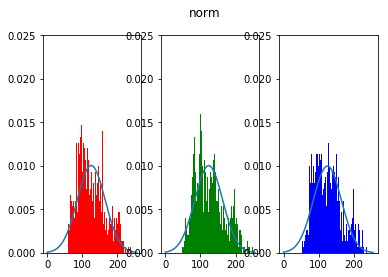

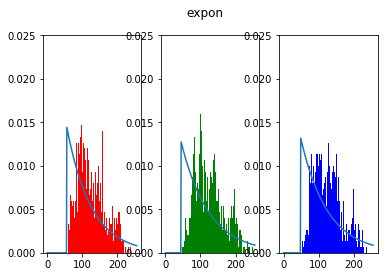

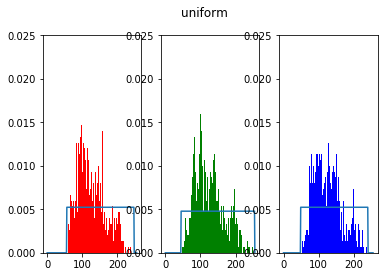

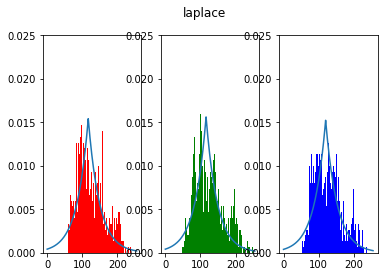

{'mse_beta': 0.0024567535900088516,
 'mse_norm': 0.003789047734610342,
 'mse_expon': 0.010899737234991706,
 'mse_uniform': 0.009140045345884609,
 'mse_laplace': 0.005137729665750408}

In [12]:
def get_distributions(img, plotting=False):
    result = dict()
    if plotting:
        fig = plt.figure()
        dist = "origin"
        for ch in range(img.img.shape[-1]):
            flatten = img.img[ch].flatten()
            lnspc = np.linspace(0, 255, 256)
            hist = np.histogram(flatten, bins=lnspc, density=True)
            plt.subplot(1, 3, ch + 1)
            plt.hist(flatten, lnspc, density=True, color=RGB[ch])
            plt.suptitle(dist)
            plt.ylim((0, 0.025))
            plt.savefig(f'{dist}.png')   
    for dist in DISTRIBUTIONS:
        if plotting:
            fig = plt.figure()
        mse = list()
        for ch in range(img.img.shape[-1]):
            flatten = img.img[ch].flatten()
            lnspc = np.linspace(0, 255, 256)
            hist = np.histogram(flatten, bins=lnspc, density=True)
            if plotting:
                plt.subplot(1, 3, ch + 1)
                plt.hist(flatten, lnspc, density=True, color=RGB[ch])

            distribution = getattr(scipy.stats, dist)

            if dist == "beta":
                args = distribution.fit(flatten) # get mean and standard deviation
            else:
                args = distribution.fit(flatten) # get mean and standard deviation

            for b in range(len(hist[0])):
                y = hist[0][b]
                expected = distribution.pdf(hist[1][b], *args)
                err = np.power(y - expected, 2.0)

                mse.append(err)


            pdf_g = distribution.pdf(lnspc, *args) # now get theoretical values in our interval

            if plotting:
                plt.plot(lnspc, pdf_g, label="Norm") # plot it
                plt.suptitle(dist)
                plt.ylim((0, 0.025))
                plt.savefig(f'{dist}.png')
                
        result.update({f"mse_{dist}": np.mean(np.sum(mse))}) 
        

    if plotting:
        plt.show()
    return result

image = np.array(Image.open(filename))
img = Img(image)
prop = get_properties(img)
for p in prop.keys():
    print(f"{p}: {prop[p]}")
get_distributions(img, True)

### 5. Make result distribution 

In [7]:
distributions = {"norm": 0, "expon": 0, "uniform": 0, "laplace": 0, "beta": 0}
with open(filename_output, "w") as f:
    csvfile = csv.DictWriter(f, fieldnames=fieldnames)
    csvfile.writeheader()
    for image in os.listdir(images_dir):
        result = dict()
        img = Img(np.array(Image.open(f"{images_dir}{image}")))
        result.update(get_properties(img))
        d = get_distributions(img)

        l = [d["mse_norm"], d["mse_expon"], d["mse_beta"], d["mse_laplace"], d["mse_uniform"]]
        if np.nan in l:
            result.update(d)
            csvfile.writerow(result)
            continue
        ind = l.index(min(l))

#         print(f"{l} {ind}")
        if ind == 0:
            distributions["norm"] += 1
        elif ind == 1:
            distributions["expon"] += 1
        elif ind == 2:
            distributions["beta"] += 1
        elif ind == 3:
            distributions["laplace"] += 1
        else:
            distributions["uniform"] += 1
        result.update(d)
        csvfile.writerow(result)
print(distributions)


{'norm': 13, 'expon': 20, 'uniform': 22, 'laplace': 15, 'beta': 40}
